# South Korea Pollution
## Pollutant levels in South Korea
#### https://www.kaggle.com/datasets/calebreigada/south-korean-pollution/data
#### Our goal is to forecast level of pollution in one of the South Korea's city.

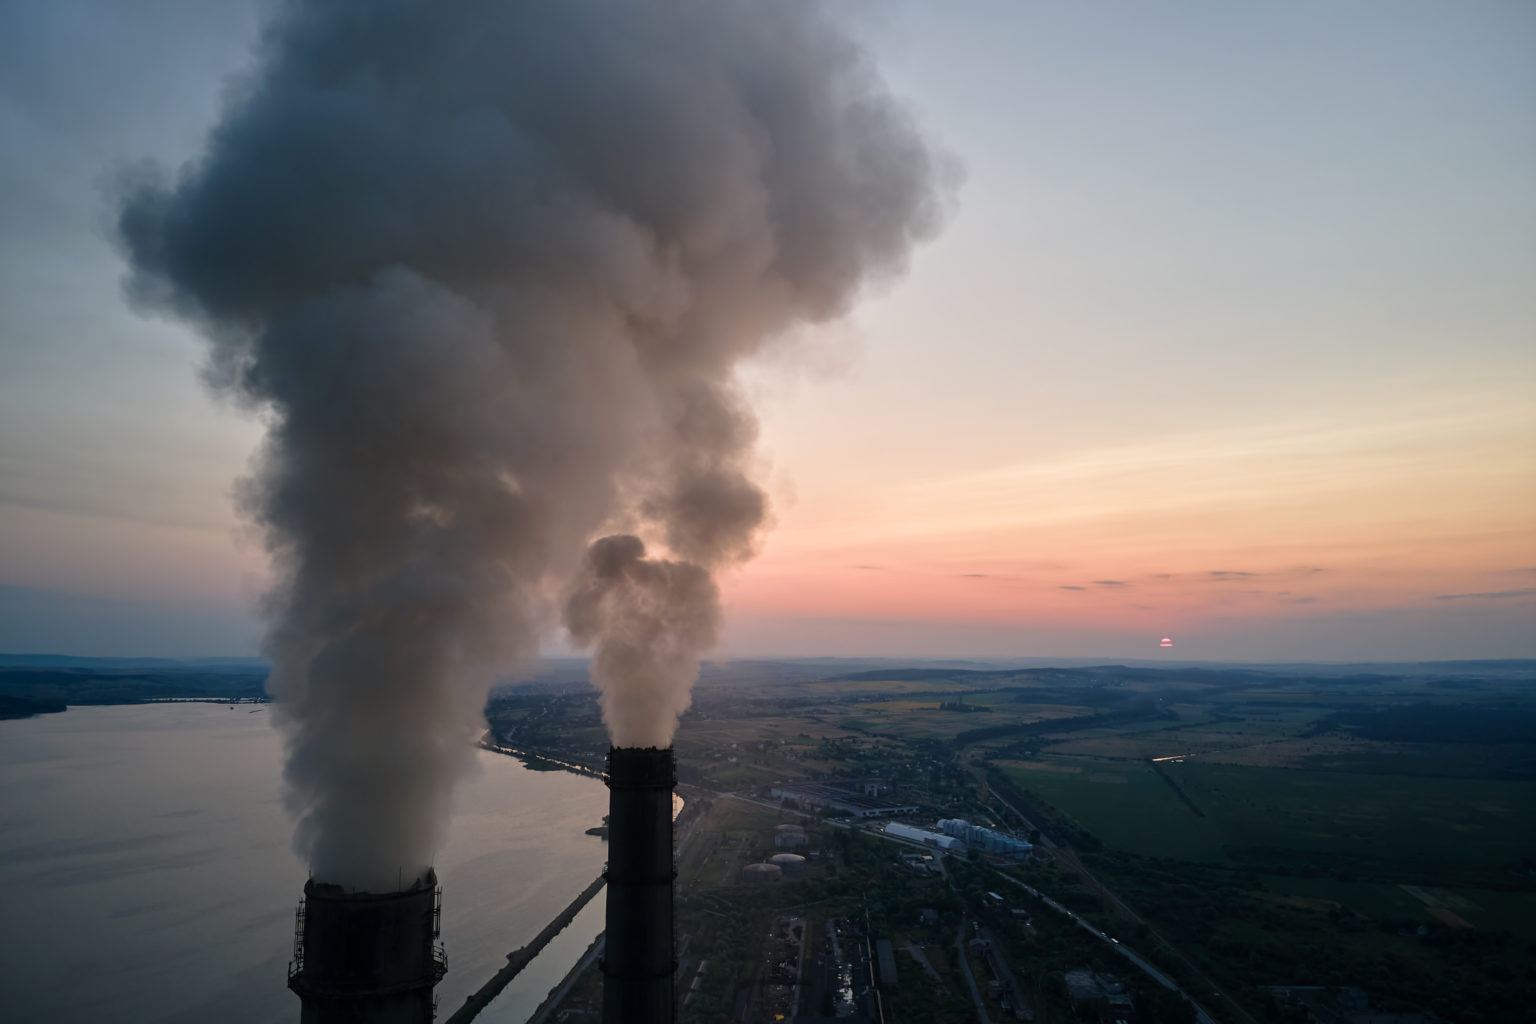

In [1]:
from IPython.display import Image 
pil_img = Image(filename='pollution.jpg', 
                width=500,
                height=500)
display(pil_img)

# Project
#### The goal of the project was to recall and reuse skills developed during Coursera's course: "Sequences, Time Series and Prediction".
#### The code used in the notebook has been based on the code developed during the course.
#### For this purpose the following Kaggle's use case has been used: https://www.kaggle.com/datasets/calebreigada/south-korean-pollution/data.

In [2]:
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
df = pd.read_csv('south-korean-pollution-data.csv')
df.head()

,Unnamed: 0,date,pm25,pm10,o3,no2,so2,co,Lat,Long,City,District,Country
0,0,2022/2/1,112,31,35,2,1,4,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
1,1,2022/2/2,92,21,35,2,1,0,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
2,2,2022/2/3,60,20,35,1,1,4,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
3,3,2022/2/4,51,27,33,1,1,4,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea
4,4,2022/2/5,57,24,27,2,1,5,38.2089,127.9495,Bangsan-Myeon,Gangwon,South Korea


In [4]:
df.City.value_counts()

Nowon-Gu           2891
Geumchon-Dong      2888
Gwanak-Gu          2880
Jeongnim-Dong      2880
Juwol-Dong         2865
Bangsan-Myeon      2863
Seolseong-Myeon    2832
Jungang-Way        2816
Pado-Ri            2766
Paju               1603
Sangjusi           1456
Seonggeoeup        1449
Hwasun-Eup         1071
Cheongnim-Dong      804
Hyeoksin-Dong       610
Soi-Myeon           610
Onui-Dong           610
Saesol-Dong         606
Saemangeum           15
Taeha-Ri             15
Name: City, dtype: int64

In [5]:
df = df[df['City'] == 'Geumchon-Dong'].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2888 non-null   int64  
 1   date        2888 non-null   object 
 2   pm25        2888 non-null   int64  
 3   pm10        2888 non-null   int64  
 4   o3          2888 non-null   int64  
 5   no2         2888 non-null   int64  
 6   so2         2888 non-null   int64  
 7   co          2888 non-null   int64  
 8   Lat         2888 non-null   float64
 9   Long        2888 non-null   float64
 10  City        2888 non-null   object 
 11  District    2888 non-null   object 
 12  Country     2888 non-null   object 
dtypes: float64(2), int64(7), object(4)
memory usage: 293.4+ KB


In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
times = df.date.tolist()
pollutions = df.pm10.tolist()

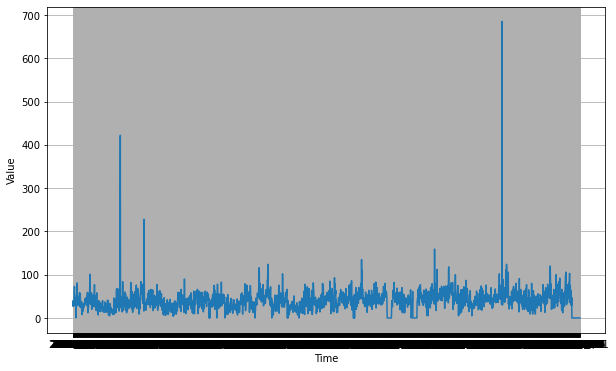

In [8]:
@dataclass
class G:
    TIME = np.array(times)
    SERIES = np.array(pollutions)
    SPLIT_TIME = 2400
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

### Processing the data

In [9]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [10]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Naive Forecast

Our baseline.

In [11]:
# Generate the naive forecast
split_time = G.SPLIT_TIME
series = G.SERIES
naive_forecast = series[split_time - 1:-1]

In [12]:
def plot_series2(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

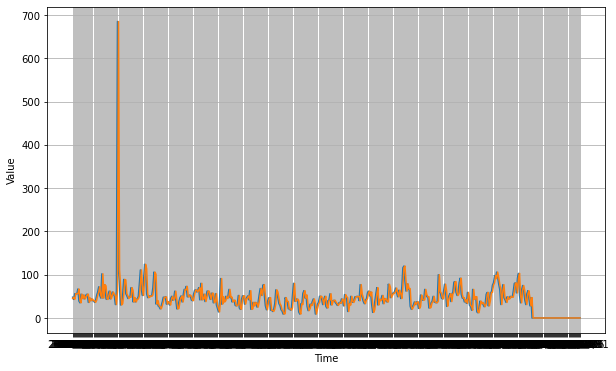

In [13]:
# Plot the results
plot_series2(time_valid, (series_valid, naive_forecast))

### Computing Metrics

In [14]:
print(tf.keras.metrics.mean_squared_error(series_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, naive_forecast).numpy())

1750
14


## Moving Average

In [15]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []

    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
        forecast.append(np.array(series[time:time + window_size]).mean())

    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

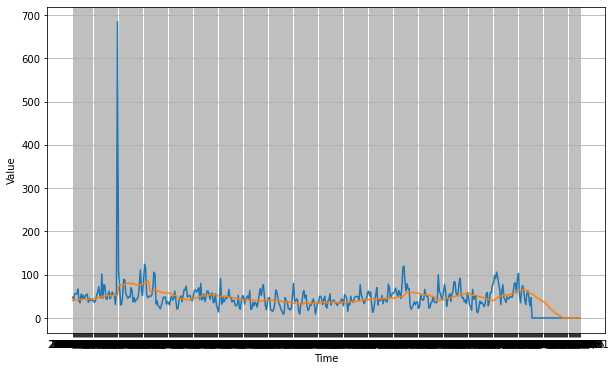

In [16]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series2(time_valid, (series_valid, moving_avg))

In [17]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(series_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, moving_avg).numpy())

1232.9143465391621
16.68790983606557


## DL Model
### Processing data

In [18]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [19]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

### Defining the model architecture

In [20]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)     
    ]) 

    return model

## Adjusting the learning rate

In [21]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
    
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [22]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
73/73 [==============================] - 9s 50ms/step - loss: 39.0929 - mae: 39.5891 - lr: 1.0000e-05
Epoch 2/100
73/73 [==============================] - 3s 36ms/step - loss: 38.8160 - mae: 39.3144 - lr: 1.1220e-05
Epoch 3/100
73/73 [==============================] - 3s 37ms/step - loss: 38.4950 - mae: 38.9945 - lr: 1.2589e-05
Epoch 4/100
73/73 [==============================] - 3s 45ms/step - loss: 38.0831 - mae: 38.5830 - lr: 1.4125e-05
Epoch 5/100
73/73 [==============================] - 3s 45ms/step - loss: 37.5495 - mae: 38.0495 - lr: 1.5849e-05
Epoch 6/100
73/73 [==============================] - 3s 39ms/step - loss: 36.8560 - mae: 37.3560 - lr: 1.7783e-05
Epoch 7/100
73/73 [==============================] - 3s 43ms/step - loss: 35.9330 - mae: 36.4329 - lr: 1.9953e-05
Epoch 8/100
73/73 [==============================] - 3s 46ms/step - loss: 34.8101 - mae: 35.3098 - lr: 2.2387e-05
Epoch 9/100
73/73 [==============================] - 3s 46ms/step - loss: 33.5378 - mae:

(1e-05, 0.1, 0.0, 20.0)

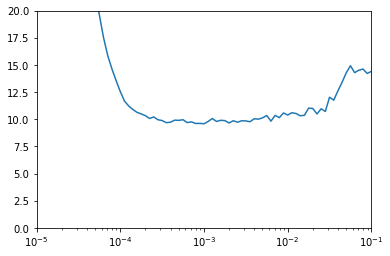

In [46]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 20])

## Compiling the model

In [47]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3),
                  metrics=["mae"])  
    
    return model

In [53]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=100)

Epoch 1/100
73/73 [==============================] - 10s 52ms/step - loss: 17.9984 - mae: 18.4936
Epoch 2/100
73/73 [==============================] - 4s 58ms/step - loss: 11.8700 - mae: 12.3625
Epoch 3/100
73/73 [==============================] - 4s 56ms/step - loss: 10.3667 - mae: 10.8560
Epoch 4/100
73/73 [==============================] - 5s 66ms/step - loss: 10.2189 - mae: 10.7048
Epoch 5/100
73/73 [==============================] - 6s 70ms/step - loss: 10.0693 - mae: 10.5526
Epoch 6/100
73/73 [==============================] - 4s 52ms/step - loss: 9.9986 - mae: 10.4801
Epoch 7/100
73/73 [==============================] - 4s 49ms/step - loss: 10.0994 - mae: 10.5817
Epoch 8/100
73/73 [==============================] - 3s 40ms/step - loss: 9.9677 - mae: 10.4514
Epoch 9/100
73/73 [==============================] - 4s 49ms/step - loss: 9.7367 - mae: 10.2191
Epoch 10/100
73/73 [==============================] - 4s 49ms/step - loss: 10.2873 - mae: 10.7705
Epoch 11/100
73/73 [===========

## Evaluating the forecast

In [54]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Faster model forecasts

In [55]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

89/89 [==============================] - 3s 18ms/step


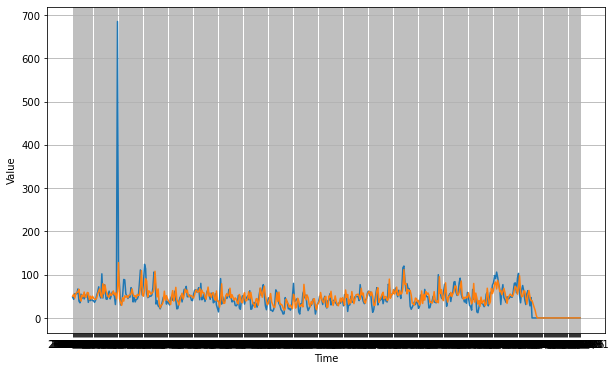

In [56]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [57]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1067.63, mae: 13.27 for forecast


**As we can see the results received from the DL model are slightly better than our Naive Forecast. For sure there are many opportunities to improve our model. We could try to change the number of epochs, butch sizes, window sizes and of course architecture of the whole model.**